# Choice Function

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from csrank import *
from keras.optimizers import SGD

Using TensorFlow backend.


## Learning Pareto-Optimality

We now try to solve the problem of predicting the Pareto-optimal set of points $O \subseteq X$.
In other words, it is the set of points which or not dominated by any other point.

Let us plot a small example:

In [2]:
from csrank import ChoiceDatasetGenerator
seed = 123
n_train = 10000
n_test = 10000
n_features = 2
n_objects = 30
gen = ChoiceDatasetGenerator(dataset_type='pareto', random_state=seed,
                                n_train_instances=n_train,
                                n_test_instances=n_test,
                                n_objects=n_objects,
                                n_features=n_features)

In [3]:
X_train, Y_train, X_test, Y_test = gen.get_single_train_test_split()

Let us plot a random instances. The pareto points are marked with orange color.

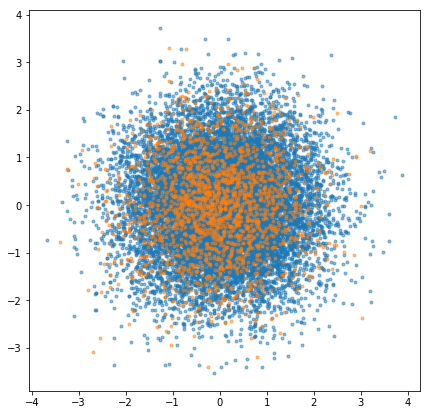

In [ ]:
colors = sns.color_palette('tab10', n_colors=2)
fig, ax = plt.subplots(figsize=(7,7))
inst = np.random.choice(n_train, size=500)
rows, cols = np.where(Y_train[inst]==1)
ax.scatter(X_train[inst].reshape(-1,2)[:, 0], X_train[inst].reshape(-1,2)[:, 1], c=[colors[0]], marker='.', alpha=0.5)
ax.scatter(X_train[rows, cols][:, 0], X_train[rows, cols][:, 1], c=[colors[1]], marker='.', alpha=0.5)
plt.show()

## The FATE network
The first-aggregate-then-evaluate approach learns an embedding of each object and then aggregates that into a _context_:
\begin{equation}
	\mu_{C(\vec{x})} = \frac{1}{|C(\vec{x})|} \sum_{\vec{y} \in C(\vec{x})} \phi(\vec{y})
\end{equation}
and then scores each object $\vec{x}$ using a generalized utility function $U (\vec{x}, \mu_{C(\vec{x})})$

In [ ]:
fate = FATEChoiceFunction(
    n_object_features=n_features,
    optimizer=SGD(lr=1e-4, nesterov=True, momentum=0.9))

We will run the training for only 10 epochs to get an idea of the convergence:

In [ ]:
fate.fit(X_train, Y_train, verbose=True, epochs=10)

Train on 8100 samples, validate on 900 samples
Epoch 1/10


In [ ]:
scores = fate.predict_scores(X_test)
y_pred = fate.predict_for_scores(scores)

In [ ]:
from csrank.metrics_np import f1_measure
f1_measure(Y_test, y_pred)

Not converged yet, but let us visualize the scores it assigns to test instances:

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
inst = np.random.choice(n_test)
choices = np.where(Y_test[inst]==1)[0]
ax.scatter(X_test[inst][:, 0], X_test[inst][:, 1])
ax.scatter(X_test[inst][choices, 0], X_test[inst][choices, 1])
for i in range(n_objects):
    if Y_test[inst, i]:
        color = 'r'
    else:
        color = 'b'
    ax.text(X_test[inst, i, 0]-0.2,
            X_test[inst, i, 1]-0.2,
            s='{:.1f}'.format(scores[inst][i]),
            color=color)